# Output File Analysis - Single SRR - Donor to Recipient Workflow

## Variables

In [2]:
## Variables
srr_name <- "SRR1609137"
donor_name <- "hpv16"
recipient_name <- "UCSChg38"
inputs_folder <- "../../wallaby/workflows/final-outputs-hpv16-wgs"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fa"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/hg38.fa"

In [3]:
## Variables
srr_name <- "SRR5090597"
donor_name <- "hpv16"
recipient_name <- "UCSChg38"
inputs_folder <- "../../wallaby/workflows/cromwell-final-outputs"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fa"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/hg38.fa"

## Import Libraries

In [4]:
## Setup Environment
# Enable multithreading when possible (library dependent)
options(Ncpus = parallel::detectCores())
Sys.setenv(OMP_NUM_THREADS=toString(parallel::detectCores()))
Sys.setenv(OMP_THREAD_LIMIT=toString(parallel::detectCores()))
Sys.setenv(OMP_NUM_THREADS=parallel::detectCores())
Sys.setenv(OMP_THREAD_LIMIT=parallel::detectCores())

## Load or install and load all libraries
suppressPackageStartupMessages(library("pacman", character.only = TRUE))

# List of CRAN packages to either Load, or Install and Load
pacman::p_load(dplyr, ggplot2, shiny, shinyLP, DT,  ggrepel,  tidyr, 
               data.table, kableExtra, knitr, IRdisplay, install = FALSE)

# List of Bioconductor packages to either Load, or Install and Load
pacman::p_load(BSgenome, BSgenome.Hsapiens.UCSC.hg38, GenomicFeatures, 
               GenomicAlignments,  Rsubread,  Rsamtools, bamsignals,  
               rtracklayer, GenomicRanges, org.Hs.eg.db, Organism.dplyr,
               TxDb.Hsapiens.UCSC.hg38.knownGene, regioneR, karyoploteR,
               seqinr, Repitools, Gviz, Biostrings, install = FALSE)

## Load Files for Analysis

In [5]:
# Select crossings to import and order of visualization
crossings <- c("UMd_MMr", "MUd_MMr", "UMd_MUr", "MUd_UMr", "MMd_UMr", "MMd_MUr")

In [6]:
# Load all .bed files created by the cromwell workflow
donor_granges <- list()
donor_granges_crossings <- list()
recip_granges <- list()
recip_granges_crossings <- list()

for (cross in crossings){
    # list all donor files
    donor_file <- list.files(inputs_folder, 
                              pattern=paste(srr_name, 
                                            '-to-',
                                            donor_name, 
                                            "_", cross, 
                                            ".bed", 
                                            sep = ""), 
                              recursive = TRUE,
                              full.names = TRUE)
    
    # check whether the file exists and add if it does
    if (!identical(donor_file, character(0))) {
        donor_granges[[length(donor_granges) + 1]] <- import(donor_file)
        donor_granges_crossings[[length(donor_granges_crossings) + 1]] <- cross
    }
    
    # list all recipient files
    recip_file <- list.files(inputs_folder,
                              pattern=paste(srr_name, 
                                            '-to-',
                                            recipient_name,
                                            "_", cross, 
                                            ".bed", 
                                            sep = ""), 
                              recursive = TRUE, 
                              full.names = TRUE)
    
    # check whether the file exists and add if it does
    if (!identical(recip_file, character(0))) {
        recip_granges[[length(recip_granges) + 1]] <- import(recip_file)
        recip_granges_crossings[[length(recip_granges_crossings) + 1]] <- cross
    }
   
}

In [7]:
# Load recipient .bam files created by the cromwell workflow
recip_bams <- list()
recip_bam_crossings <- list()

for (cross in crossings){
    # list all donor files
    recip_file <- list.files(inputs_folder,
                              pattern=paste(srr_name, 
                                            '-to-',
                                            recipient_name,
                                            "_", cross, 
                                            ".bam$", 
                                            sep = ""), 
                              recursive = TRUE, 
                              full.names = TRUE)
    
    # check whether they exist and add if they do
    if (!identical(recip_file, character(0))) {
        recip_bams[[length(recip_bams) + 1]] <- recip_file
        recip_bam_crossings[[length(recip_bam_crossings) + 1]] <- cross
    }
}

## Helper Functions

In [8]:
# Function to create a visualization of the donor crossings
create_viz_donor <- function(ref_genome = "hg38", 
                             granges, 
                             granges_labels,
                             title_prepend = "") {

    # reverse order of granges and granges_labels so that they plot in the right order
    # as plotKaryotype reverses it again
    granges <- rev(granges)
    granges_labels <- rev(granges_labels)
    
    # Set up plot parameters
    plot.type <- 4
    tracks <- length(granges)
    track_sep <- 0.05
    track_width <- 1 / (tracks) - track_sep
    window.size <- 10
    title <- paste(title_prepend, "- reads density graph - window size (in bases): ", window.size)
    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.17
    
    # Create a custom granges object for the Donor Reference Genome
    summary_fasta <- summary(read.fasta(ref_genome))
    total_genome_length <- as.integer(summary_fasta[, "Length"])
    seqname <- unique(as.character(seqnames(granges[[1]])))
    custom.genome <- toGRanges(data.frame(chr = c(seqname), 
                                          start = c(1), 
                                          end = c(total_genome_length)))
    
    # Create the object for plotting
    kp <- plotKaryotype(genome = custom.genome,
                        plot.type = plot.type, 
                        plot.params = pp, 
                        labels.plotter = NULL, 
                        main = title,
                        cex = 2)
    kpAddBaseNumbers(kp, tick.dist = window.size * 50, add.units = TRUE, cex = 2) 

    # Create the tracks in the plot, depending on how many tracks there are
    track_no <- 0
    for (grange in granges) {
        track_no <- track_no + 1
        
        r0 <- (track_no-1) * track_width + (track_no-1) * track_sep
        r1 <- track_no * track_width + (track_no-1) * track_sep
        
        kp <- suppressWarnings(kpPlotDensity(kp, data = grange, 
                                             window.size = window.size, 
                                             col = "blue", r0 = r0, r1 = r1))
        kpAxis(kp, ymax = kp$latest.plot$computed.values$max.density, 
               cex = 2, 
               r0 = r0, r1 = r1)
        kpAddLabels(kp, labels = granges_labels[track_no], 
                    r0 = r0, r1 = r1, 
                    label.margin = 0.07, cex = 2)
    }
}

In [9]:
# Function to Create a Table mapping ranges of overlapping paired-end crossings 
summary_table_donor <- function(granges, 
                                granges_labels, 
                                min_num_crossings = 3, 
                                min_num_reads = 3) {
    
    # convert all granges to dataframes
    granges_df <- lapply(granges, annoGR2DF) 
    # assign all granges labels (crossing names) as each dataframe's name
    names(granges_df) <- granges_labels 
    # flatten all dataframes into a single dataframe, 
    # and use their's respective name as an identifier in a new column named 'crossing'
    merged_df <- bind_rows(granges_df, .id = "crossing") 
    # convert the data.frame to a data.table
    merged_dt <- as.data.table(merged_df)

    # assign each row to a group, based on whether their ranges overlap
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    # aggregate results by group, and add additional aggregated columns
    merged_final <- merged_dt[, list(start=min(start), 
                                     stop=max(end), 
                                     num_crossings=length(unique(list(crossing)[[1]])),
                                     unique_crossings=list(unique(crossing)),
                                     num_reads=length(list(name)[[1]])
                                     ), by=list(group,chr)]
    
    # filter results using a minimum number of reads and/or crossings
    merged_final <- merged_final[merged_final[, num_reads > (min_num_reads - 1)]]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    # delete the 'group' column
    merged_final <- merged_final[, !"group"]

    # format the final table
    merged_final %>%
    kable("html") %>%
        kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
        as.character() %>%
        display_html()   
}

In [10]:
# Function to create a visualization of the recipient crossings
create_viz_recipient <- function(graph_type = "recipient", 
                                 ref_genome = "hg38", 
                                 granges,
                                 granges_labels, 
                                 title_prepend = "") {

    # reverse order of granges and granges_labels so that they plot in the right order
    # as plotKaryotype reverses it again
    granges <- rev(granges)
    granges_labels <- rev(granges_labels)
    
    # Set up plot parameters
    plot.type <- 4
    tracks <- length(granges)
    track_sep <- 0.05
    track_width <- 1 / (tracks) - track_sep
    genome = "hg38"
    window.size <- 1e6
    title <- paste(title_prepend, "- reads density graph - window size (in bases): ", window.size)
    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.17
    
    # Create the object for plotting
    kp <- plotKaryotype(genome = ref_genome,
                        plot.type = plot.type, 
                        plot.params = pp, 
                        labels.plotter = NULL, 
                        main = title,
                        cex = 2)
    kpAddChromosomeNames(kp, srt = 90, cex = 2) 
    
    # Create the tracks in the plot, depending on how many tracks there are
    track_no <- 0
    for (grange in granges) {
        track_no <- track_no + 1
        
        r0 <- (track_no-1) * track_width + (track_no-1) * track_sep
        r1 <- track_no * track_width + (track_no-1) * track_sep
        
        kp <- suppressWarnings(kpPlotDensity(kp, data = grange, 
                                             window.size = window.size, col = "blue", 
                                             r0 = r0, r1 = r1))
        kpAxis(kp, ymax = kp$latest.plot$computed.values$max.density, 
               cex = 2, 
               r0 = r0, r1 = r1)
        kpAddLabels(kp, labels = granges_labels[track_no], 
                    r0 = r0, r1 = r1,
                    label.margin = 0.07, cex = 2)
    }
}

In [11]:
# Create a sqlite database from TxDb and corresponding Org packages
# The database provides a convenient way to map between gene, transcript, and protein identifiers.
src <- suppressMessages(suppressWarnings(src_organism("TxDb.Hsapiens.UCSC.hg38.knownGene")))
# Create a full genome sequences for Homo sapiens (Human) as provided by UCSC (hg38, based on GRCh38.p12)
Hsapiens <- BSgenome.Hsapiens.UCSC.hg38

In [12]:
# Function to Create a Table mapping ranges of overlapping paired-end crossings 
summary_table_recipient <- function(granges, 
                                    granges_labels, 
                                    min_num_crossings = 3,
                                    min_num_reads = 3, 
                                    src,
                                    Hsapiens) {
    
    # convert all granges to dataframes
    granges_df <- lapply(granges, annoGR2DF)
    # assign all granges labels (crossing names) as each dataframe's name
    names(granges_df) <- granges_labels
    # flatten all dataframes into a single dataframe, 
    # and use their's respective name as an identifier in a new column named 'crossing'
    merged_df <- bind_rows(granges_df, .id = "crossing")
    # convert the data.frame to a data.table
    merged_dt <- as.data.table(merged_df)

    # assign each row to a group, based on whether their ranges overlap
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    # aggregate results by group, and add additional aggregated columns
    merged_final <- merged_dt[, list(start = min(start), 
                                     stop = max(end), 
                                     num_crossings = length(unique(list(crossing)[[1]])),
                                     unique_crossings = list(unique(crossing)),
                                     num_reads = length(list(name)[[1]])
                                     ), by = list(group,chr)]
    
    # filter results using a minimum number of reads and/or crossings
    merged_final <- merged_final[merged_final[, num_reads > (min_num_reads - 1)]]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    # use the src database to look for the gene names or each crossing overlap region
    # then, add it as a new column
    merged_final$gene_name <- apply(merged_final, 1, FUN = function(x) toString(
        unique(unlist(suppressWarnings(annoGR2DF(
                                transcripts(src, 
                                             filter=~(GRangesFilter(
                                                 GenomicRanges::GRanges(
                                                     paste(toString(x["chr"]), ":", 
                                                           as.integer(x["start"]), "-", 
                                                           as.integer(x["stop"]), sep = "")))), 
                                             columns=c("symbol")))$symbol)))))

    # use the Hsapiens databse to look up the DNA sequence for each crossing overlap region
    # then, add it as a new column
    merged_final$sequence <- apply(merged_final, 1, FUN = function(x) toString(getSeq(Hsapiens, 
                                                                       toString(x["chr"]), 
                                                                       start = as.integer(x["start"]), 
                                                                       end = as.integer(x["stop"]))))
    # delete the 'group' column
    merged_final <- merged_final[, !"group"]
    # add an ID to each row
    merged_final <- merged_final[, id := .I]
    setcolorder(merged_final, c("id", "chr", "start", "stop", 
                                "num_crossings", "unique_crossings", 
                                "num_reads", "gene_name", "sequence"))
    
    # format the final table
    merged_final %>%
    kable("html") %>%
        kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
        column_spec(9, width = "30em", width_max = "30em") %>%
        as.character() %>%
        display_html()

    return(merged_final)
}

In [13]:
# Function to create a visualization for specific overlap regions
plot_reads_region <- function(id = 1, 
                              crossings_table_recipient, 
                              recip_bams, 
                              crossings,
                              extend_left = 20, 
                              extend_right = 20, 
                              ref_genome) {
    
    # extend the graph to the left and right by this margin
    extend_left <- 20
    extend_right <- 20
    
    # extract chromosome, start, and end positions from the given overlap table
    chr <- toString(crossings_table_recipient[id,]$chr)
    start <- toString(crossings_table_recipient[id,]$start - extend_left) 
    end <- toString(crossings_table_recipient[id,]$stop + extend_right)
    
    # create a track which holds gene names
    options(ucscChromosomeNames=TRUE)
    gr_track <- UcscTrack(genome = "hg38", 
                          table = "ncbiRefSeq", 
                          track = 'NCBI RefSeq', 
                          trackType = "GeneRegionTrack",
                          chromosome = chr, 
                          start = start,
                          end = end,
                          rstarts = "exonStarts", 
                          rends = "exonEnds",
                          gene = "name", 
                          symbol = 'name', 
                          transcript = "name",
                          strand = "strand", 
                          showID = TRUE, 
                          geneSymbol = TRUE, 
                          showBandId = TRUE,
                          showID = TRUE,
                          name = "Gene Track", 
                          min.height = 2,
                          max.height = 3, 
                          cex.group = 1)
    
    # convert the gene names to a readable format
    z <- ranges(gr_track)
    suppressMessages(mcols(z)$symbol <- mapIds(org.Hs.eg.db, 
                                               gsub("\\.[1-9]$", "", mcols(z)$symbol), 
                                               "SYMBOL", 
                                               "REFSEQ"))
    gra_track <- gr_track
    ranges(gra_track) <- z
    
    # create a track which holds a schematic display of a chromosome
    i_track <- IdeogramTrack(genome = "hg38", 
                             chromosome = chr,
                             from = as.numeric(start) - extend_left, 
                             to = as.numeric(end) + extend_right,
                             showId = TRUE, 
                             showBandId = TRUE,
                             cex.bands = 0.4)
    
    # create a track which display the genomics axis
    g_track <- GenomeAxisTrack()
    
    # create a track which holds each letter
    s_track <- SequenceTrack(readDNAStringSet(recipient_ref_genome), 
                             chromosome = chr, 
                             ex=0.6, 
                             min.width = 0.1,
                             fontsize = 0.2)
    
    # create a track which holds the reads, showing mismatches
    a_tracks <- mapply(function(x, y) { AlignmentsTrack(x, 
                                                    name = y, 
                                                    isPaired = TRUE, 
                                                    stacking = 'full', 
                                                    alpha = 0.95, 
                                                    chromosome = chr,
                                                    min.height = 0.1,
                                                    max.height = 10, 
                                                    type = "pileup",
                                                    showMismatches=TRUE,
                                                    alpha.mismatch=1)
                                  }, 
                   recip_bams, 
                   crossings)
    
    # plot all tracks together
    options(repr.plot.width=30, repr.plot.height=30)
    plotTracks(c(i_track, g_track, gra_track, a_tracks, s_track), 
               chromosome = chr,
               col.main="black",
               cex = 1, 
               fontsize = 24,
               transcriptAnnotation = "symbol",
               from = as.numeric(start), 
               to = as.numeric(end), 
               extend.left = extend_left, 
               extend.right = extend_right,
               just.group = 'above',
               title.width = 0.3,
               sizes = c(0.5, 1, 1, replicate(length(crossings), 1), 0.25))
}

## Donor Analysis

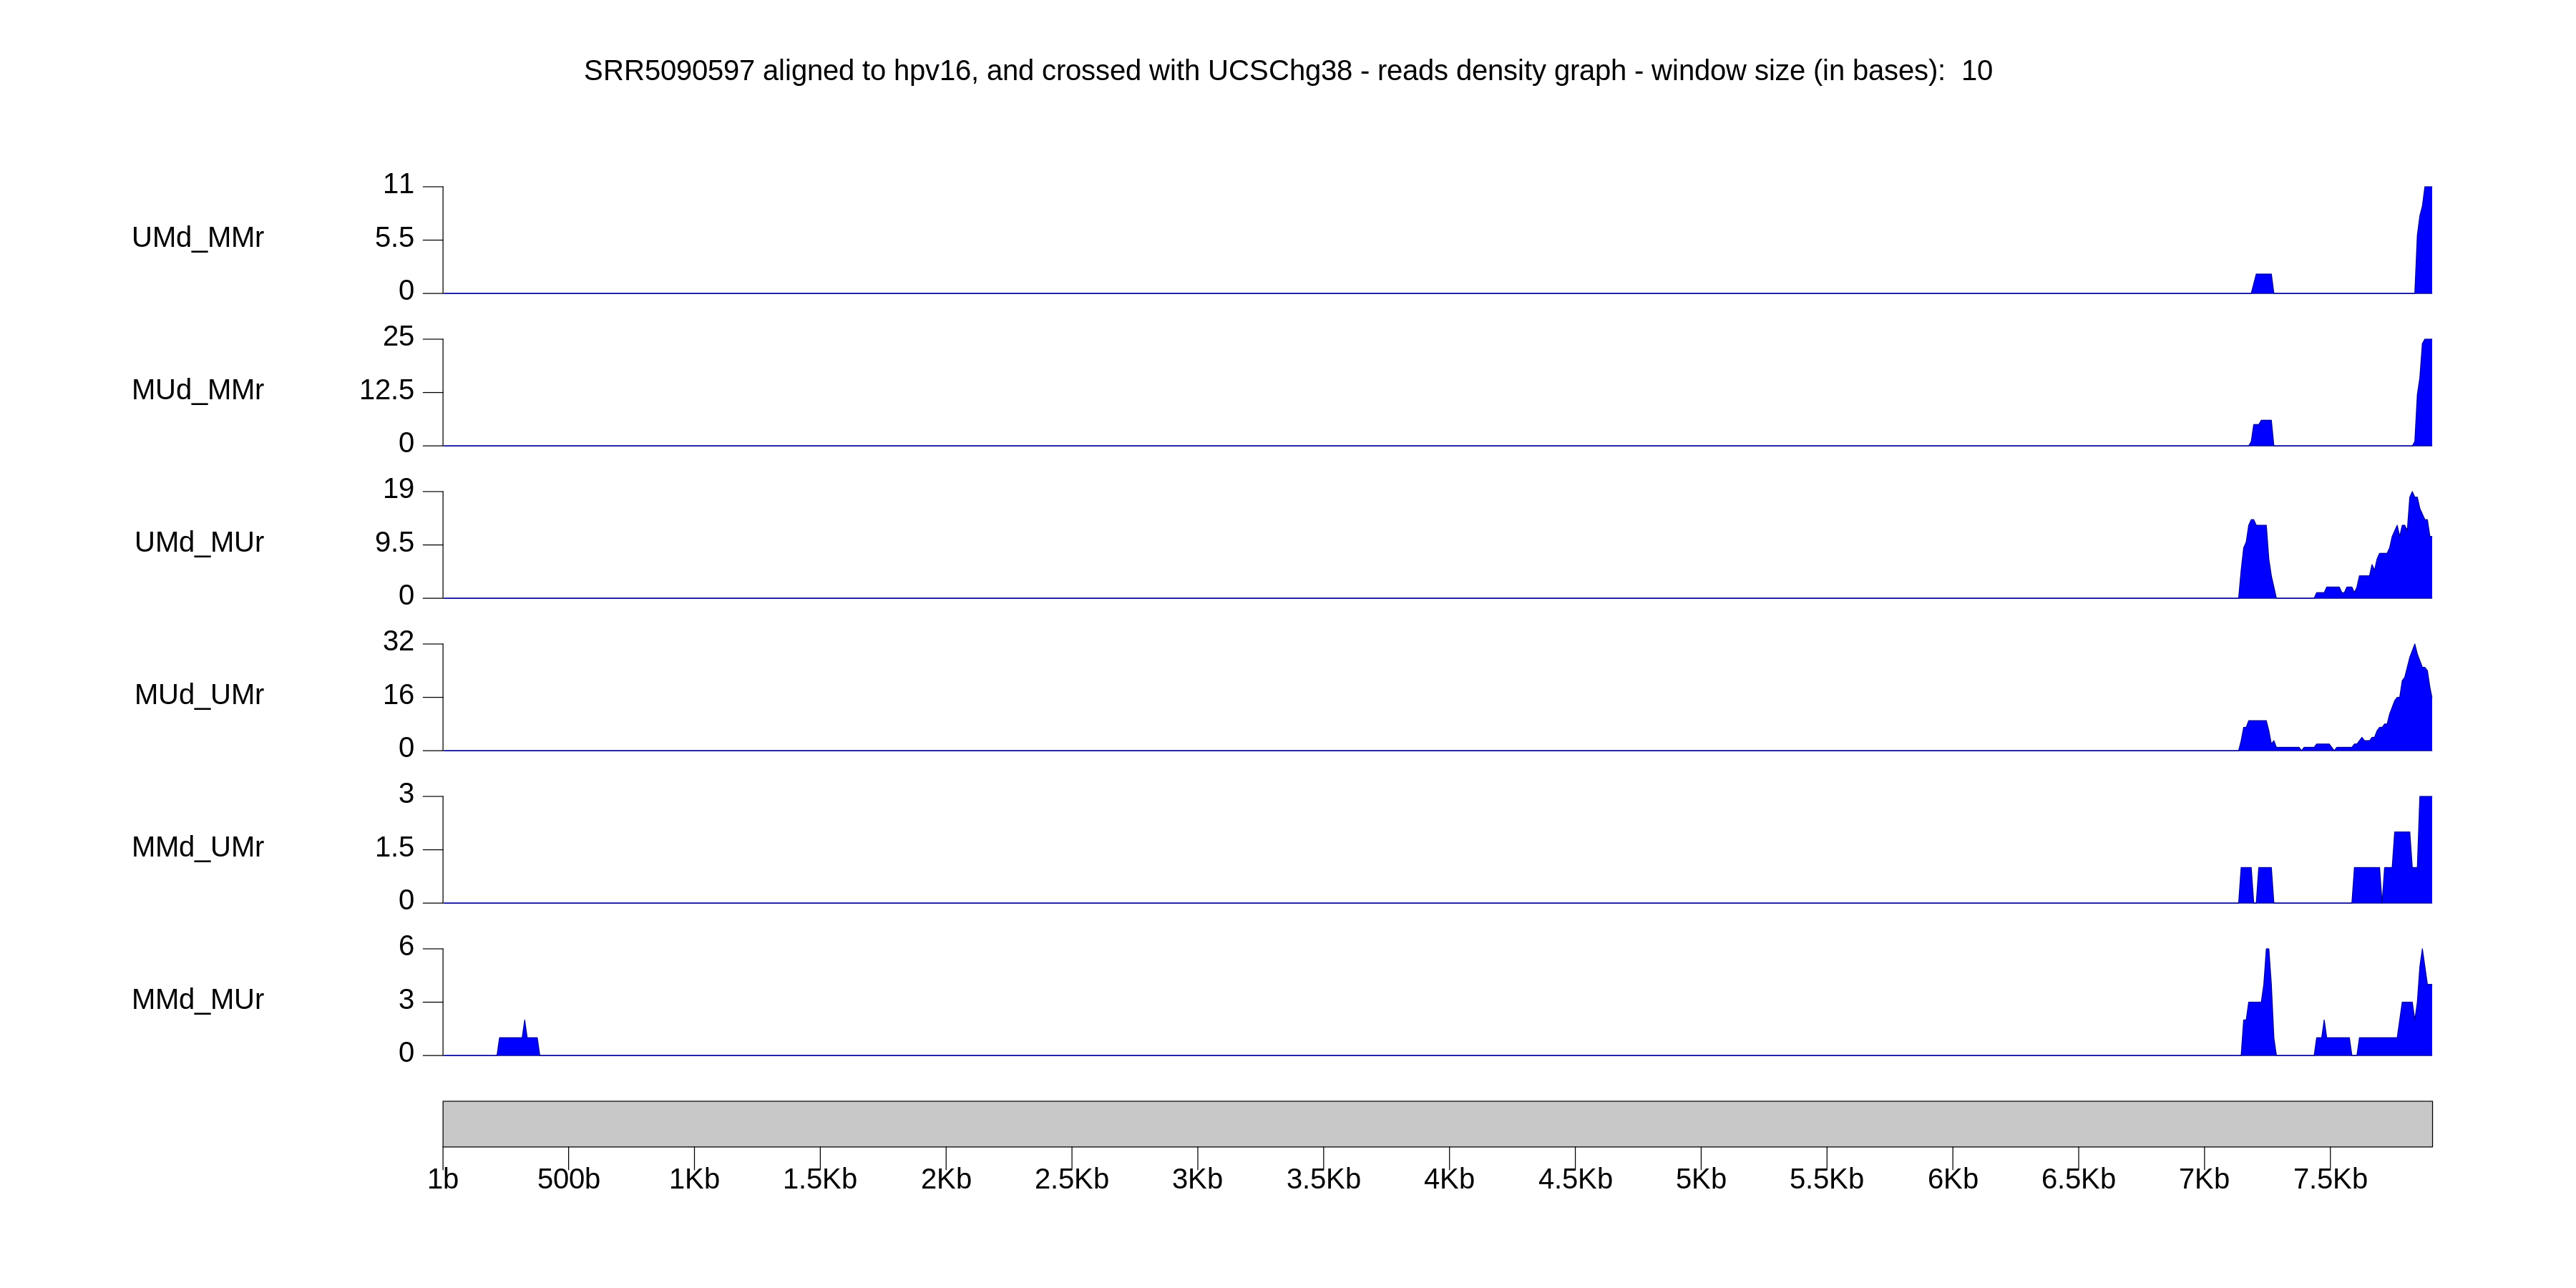

In [14]:
# Plot of all relevant crossings over the potential donor reference genome
options(repr.plot.width=30, repr.plot.height=15)
title_prepend <- paste(srr_name, ' aligned to ', donor_name, ', and crossed with ', recipient_name, sep = "")

create_viz_donor(ref_genome = donor_ref_genome, 
                 granges = donor_granges,  
                 granges_labels = donor_granges_crossings,
                 title_prepend = title_prepend)

In [15]:
# Aggregated view of all overlapping crossings for the potential donor
summary_table_donor(granges = donor_granges, 
                    granges_labels = donor_granges_crossings, 
                    min_num_crossings = 1, 
                    min_num_reads = 3)

chr,start,stop,num_crossings,unique_crossings,num_reads
NC_001526.4,7148,7371,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",40
NC_001526.4,7400,7906,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",134


## Recipient Analysis

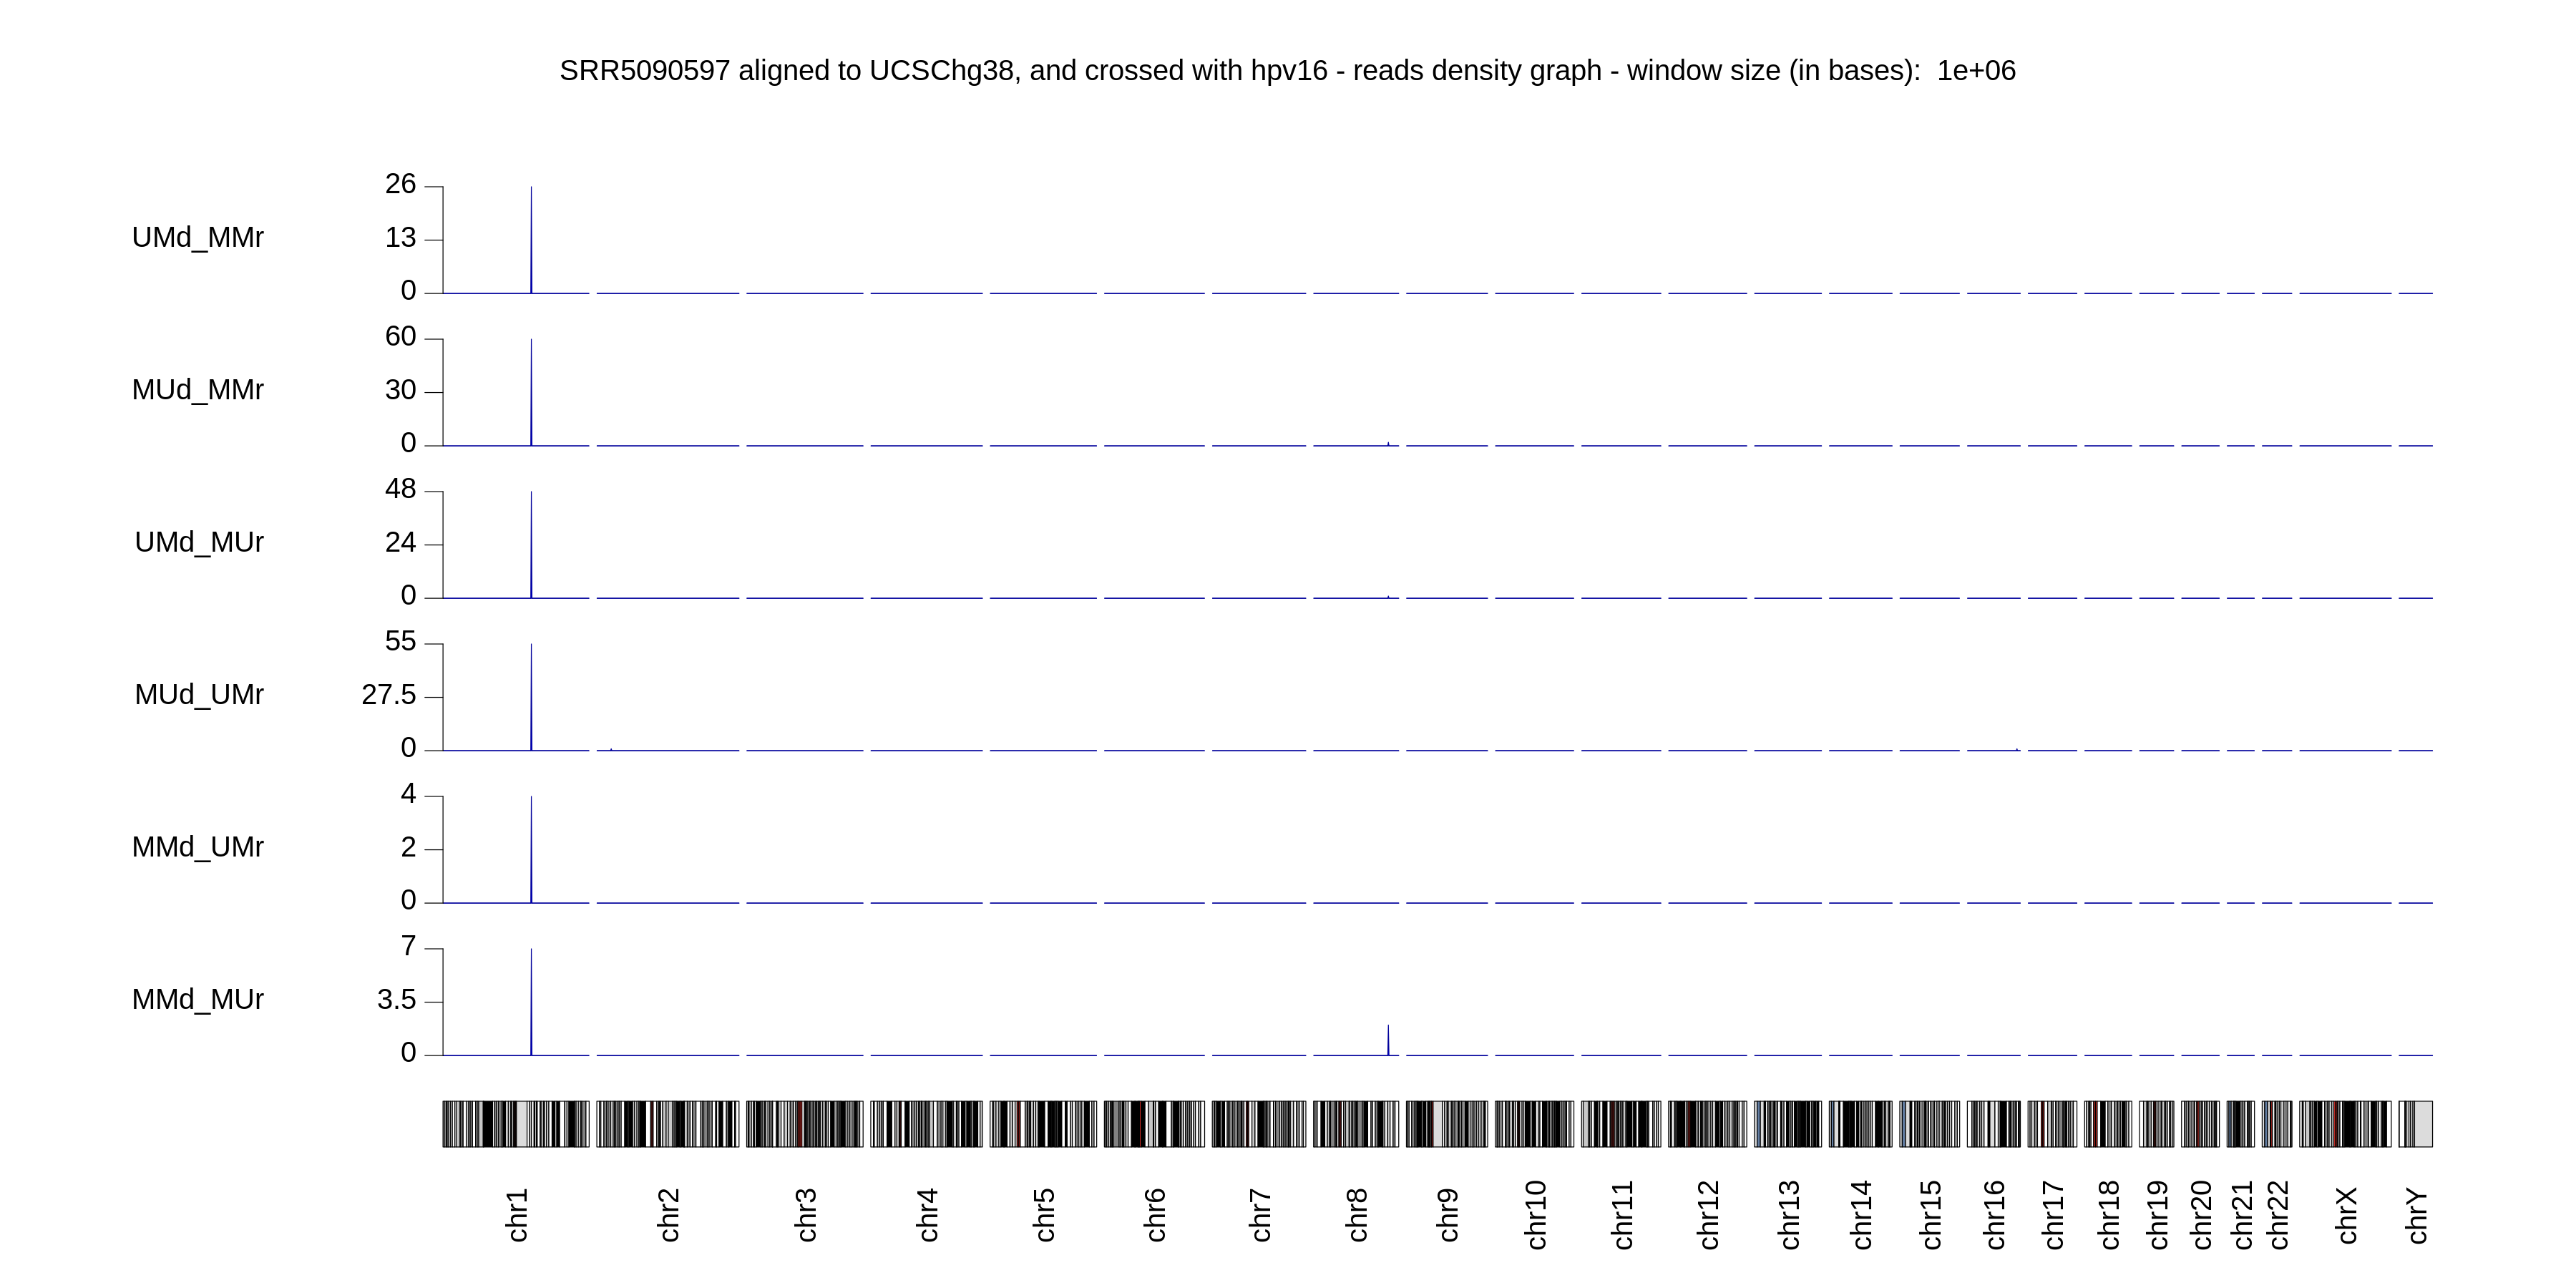

In [16]:
# Plot of all relevant crossings over the potential recipient reference genome
options(repr.plot.width=30, repr.plot.height=15)
title_prepend <- paste(srr_name, ' aligned to ', recipient_name, ', and crossed with ', donor_name, sep = "")

create_viz_recipient(ref_genome="hg38", 
                     granges = recip_granges, 
                     granges_labels = recip_granges_crossings, 
                     title_prepend = title_prepend)

In [17]:
# Aggregated view of all overlapping crossings for the potential recipient
crossings_table_recipient <- summary_table_recipient(granges = recip_granges,
                                                     granges_labels = recip_granges_crossings, 
                                                     min_num_crossings = 1, 
                                                     min_num_reads = 2, 
                                                     src = src, 
                                                     Hsapiens = Hsapiens)

id,chr,start,stop,num_crossings,unique_crossings,num_reads,gene_name,sequence
1,chr1,150577086,150577493,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",68,MCL1,CCCTACCATCTTCACTAAATCTAAAAGTCCTCCTCCATAGCTTCCCAAACAAAGTTTGTTTGTTGCTGAAACTGAACTTTGCTTCTTTCAGACAGTGACTCTTCAATCAATGGGGAGCACTCTTCCCATGTATTTATTCTTGTTAGCCATAATCCTCTTGCCACTTGCTTTTCTGGCTAGGTTGCTAGGGTGCAACTCTAGGAAGTTACAGCTTGGAGTCCAACTGCATAAACTGGTTTTGGTGGTGGTGGTGGTTGGTTAAAAGTCAACTATTGCACTTACAGTAAGGCTATCTTATTAGATATGCCAAACCAGCTCCTACTCCAGCAACACCTGCAAAAGCCAGCAGCACATTCCTGATGCCACCTTCTAGGTCCTCTACATGGAAGAACTCCACAAACCCATCCT
2,chr1,150578243,150578495,5,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_MUr",129,MCL1,CCCAGCCTCTTTGTTTAACTAGCCAGTCCCGTTTTGTCCTTACGAGAACGTCTGTGATACTTTCTGCTAATGGTTCGATGCAGCTTTCTTGGTTTATGGTCTTCAAGTGTTTAGCCACAAAGGCACCAAAAGAAATGAGAGTCACAATCCTGCCCCAGTTTGTTACGCCGTCGCTGAAAACATGGATCATCACTCGAGACAACGATTTCACATCGTCTTCGTTTTTGATGTCCAGTTTCCGAAGCATGCCTGA
3,chr8,127828233,127828354,2,"MUd_MMr, MMd_MUr",3,PVT1,CTTCTTACTGAGTGTCTAGTTCCTTGTTGTACAGGTGAGGGAAACTGAGGCCCAGAGTGGATGTGACGTTTCCGAAGGAGAGGCTCTGTAAAGTTCTGAGTAGGTGAGACTTATTATTAGCT


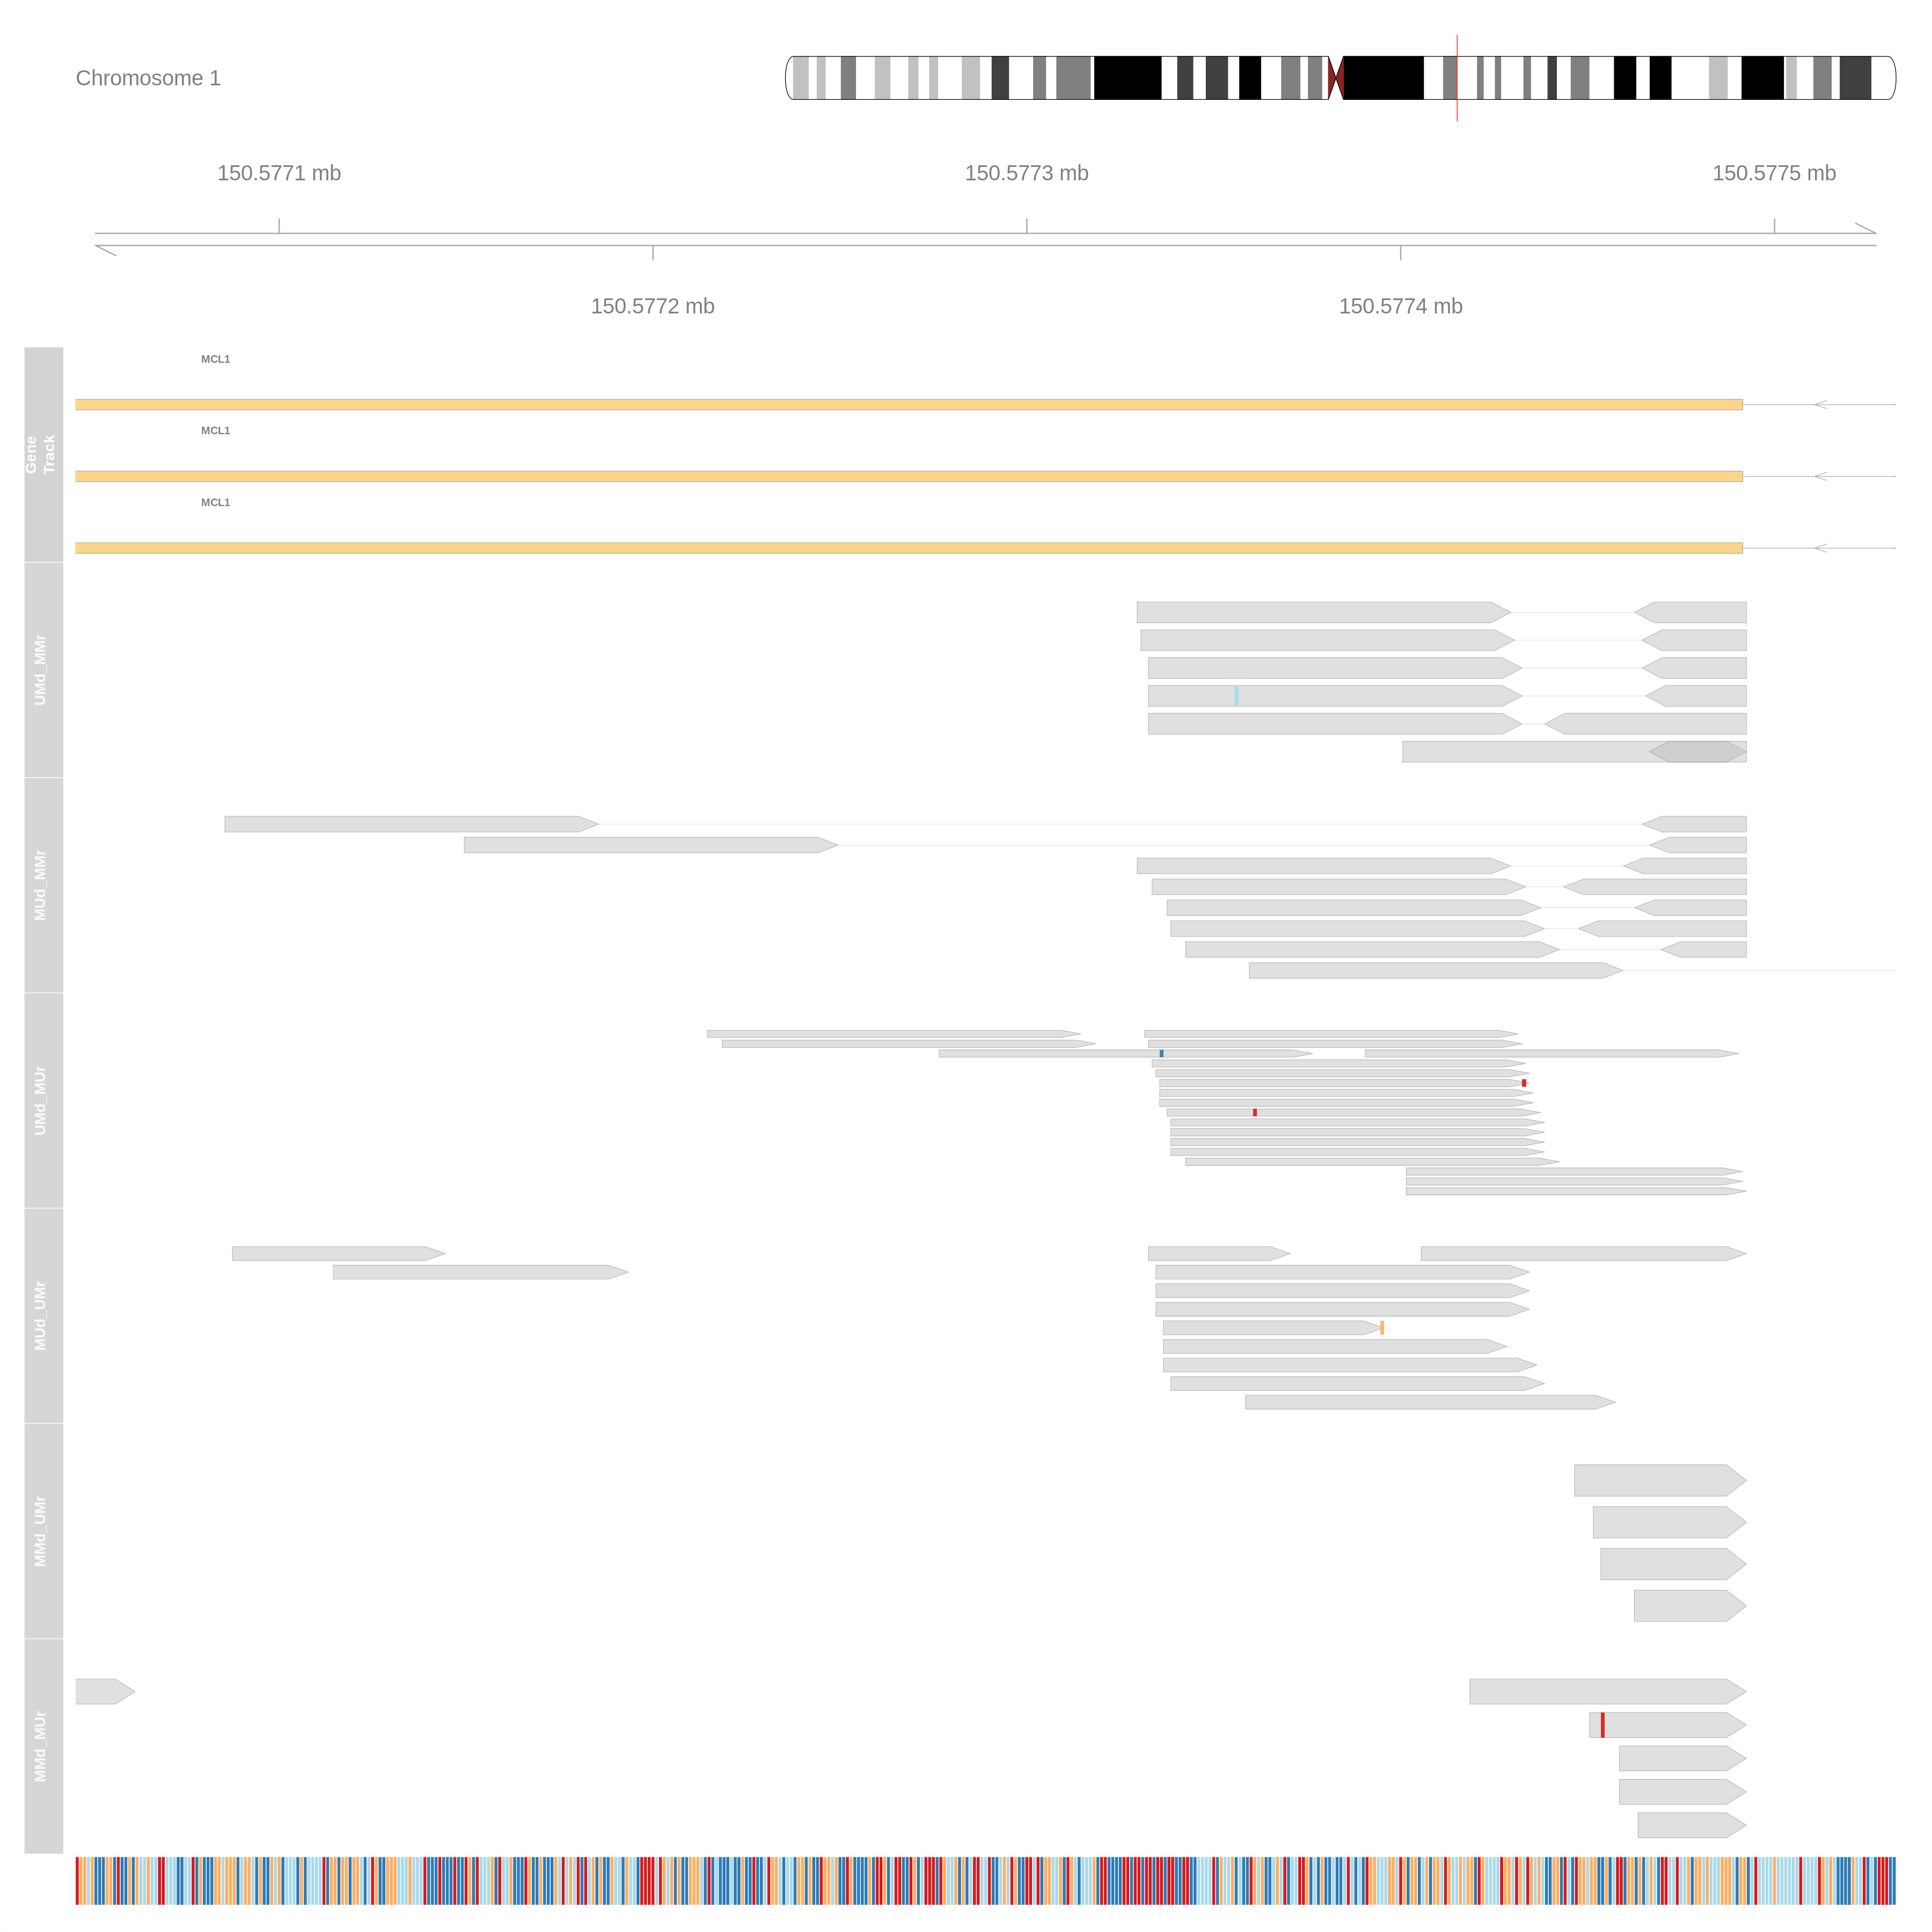

In [18]:
# Plot all the overlapping reads for a specific "id" in a single graph
plot_reads_region(id = 1, 
                  crossings_table_recipient = crossings_table_recipient, 
                  recip_bams = recip_bams,
                  crossings = recip_bam_crossings, 
                  extend_left = 20, 
                  extend_right = 20, 
                  ref_genome = recipient_ref_genome)

## Additional Work - Target Site Duplication - To Be Completed
My thoughts for now is that the TSD is probably represented as the sequence of most overlap between all reads. That should be an upper-bound for the TSD on a one-sided integration reads cluster, and a close approximation for a dual-sided integration reads cluster.

In [19]:
reads_UMd_MMr <- readGAlignments(recip_bams[[1]], param=ScanBamParam(what="seq"))
reads_MMd_UMr <- readGAlignments(recip_bams[[4]], param=ScanBamParam(what="seq"))

In [20]:
reads_UMd_MMr_df <- unique(data.frame(matrix(mcols(reads_UMd_MMr)$seq),stringsAsFactors=FALSE))
reads_MMd_UMr_df <- unique(data.frame(matrix(mcols(reads_MMd_UMr)$seq),stringsAsFactors=FALSE))

In [21]:
library(zoo)


Attaching package: 'zoo'


The following objects are masked from 'package:Rsamtools':

    index, index<-


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [22]:
reads_UMd_MMr_df[1,1]
reads_MMd_UMr_df[1,1]

[1] "GTGGTGGTGGTTGGTTAAAAGTCAACTATTGCACTTACAGTAAGGCTATCTTATTAGATATGCCAAACCAGCTCCTACTCCAGCAACACCTGCAAAAGCCA"

[1] "CACAAACCCATCCTCAATGTTGAAGATTTCTCATTTCCCAATGGAAAATAACTATTATTCTATGCAGGTCAAGAAGGGAACTGCAGGATCAGCCATGGTAG"

In [23]:
nrow(reads_UMd_MMr_df)

[1] 23

In [24]:
nrow(reads_MMd_UMr_df)

[1] 45

In [25]:
df <- data.frame(id = 1:2, seq = c(reads_UMd_MMr_df[1,1], reads_MMd_UMr_df[1,1]))
df <- with (df, data.frame (t(sapply(strsplit(as.character(seq), ""), rollapplyr, 4, paste, collapse = "")), check.names = FALSE, stringsAsFactors = FALSE))
df

1,2,3,4,5,6,7,8,9,10,⋯,89,90,91,92,93,94,95,96,97,98
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GTGG,TGGT,GGTG,GTGG,TGGT,GGTG,GTGG,TGGT,GGTT,GTTG,⋯,CCTG,CTGC,TGCA,GCAA,CAAA,AAAA,AAAG,AAGC,AGCC,GCCA
CACA,ACAA,CAAA,AAAC,AACC,ACCC,CCCA,CCAT,CATC,ATCC,⋯,TCAG,CAGC,AGCC,GCCA,CCAT,CATG,ATGG,TGGT,GGTA,GTAG


In [26]:
ncol(df)

[1] 98

In [27]:
space1 <- as.list(as.data.frame(t(df[,1])))[[1]][[1]]
space1

[1] "GTGG"

In [28]:
space2 <- as.list(as.data.frame(t(df[,2])))[[1]][[1]]
space2

[1] "TGGT"

NULL

Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(w.l):
"no non-missing arguments to min; returning Inf"
Warning message in max(w.r):
"no non-missing arguments to max; returning -Inf"


ERROR: Error in plot.window(xlim, ylim, log = log, ...): need finite 'xlim' values


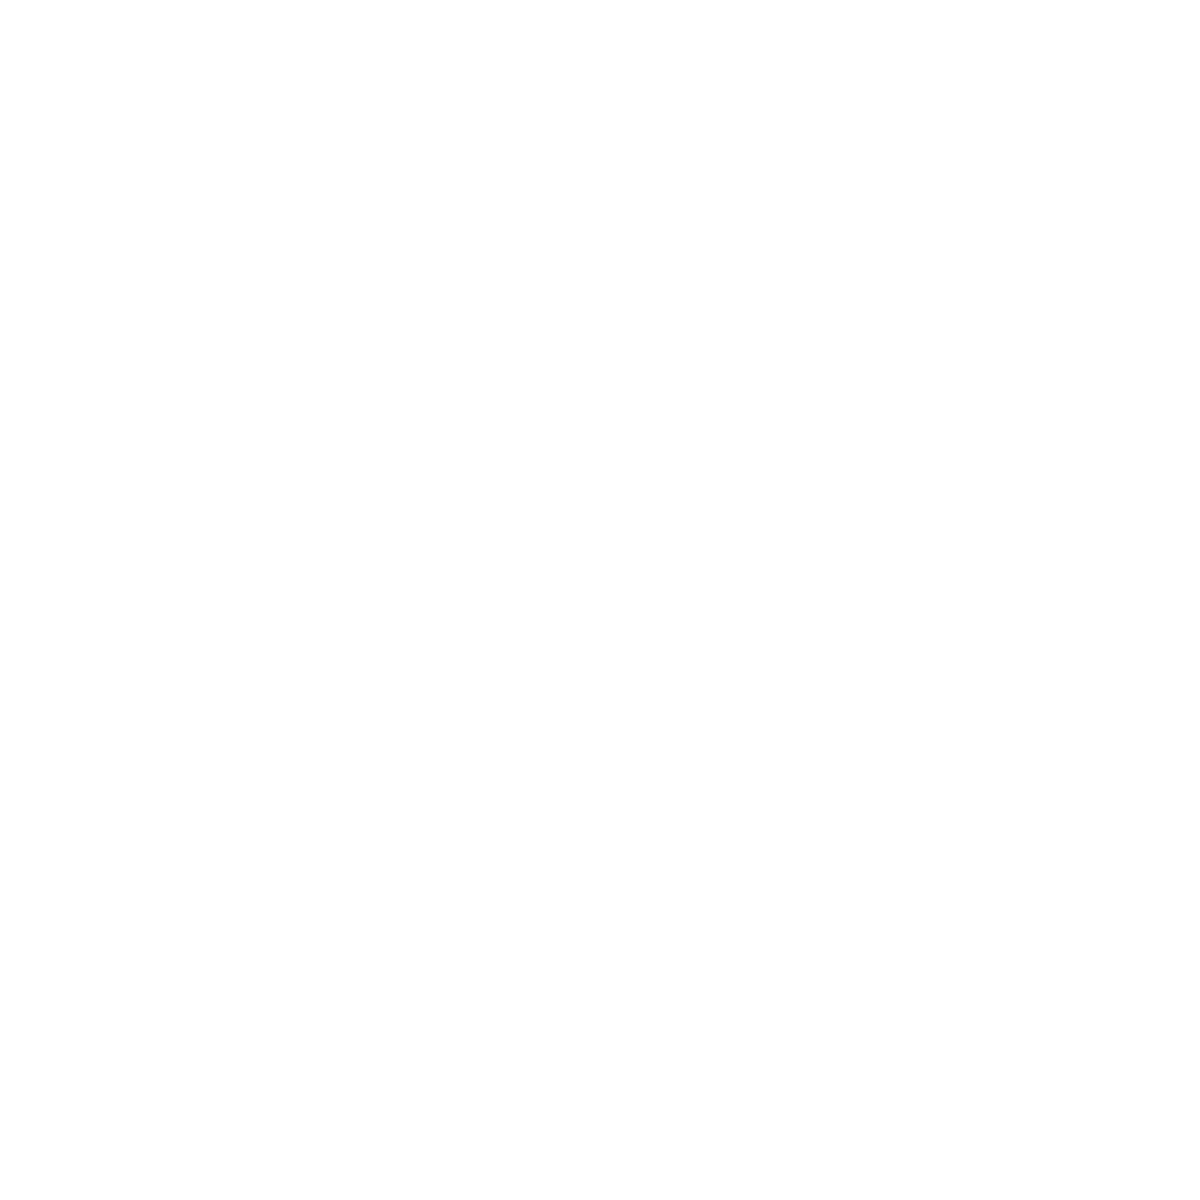

In [29]:
miniseq_in_miniseqlist <- function(miniseq, miniseqlist) {
    matches <- c()
    for (item in miniseqlist) {
        if (tolower(item) == tolower(miniseq)){
            matches <- c(matches, miniseq)
        }  
    }
    return(matches)
}

miniseqlist_in_miniseqlist <- function(miniseqlist1, miniseqlist2) {
    matches <- c()
    for (miniseq in miniseqlist1) {
        matches <- c(matches, miniseq_in_miniseqlist(miniseq, miniseqlist2))
    }
    return(matches)
}



miniseqlist_in_miniseqlist(space1, space2)

options(repr.plot.width=10, repr.plot.height=10)
barplot(table(miniseqlist_in_miniseqlist(space1, space2)), horiz=T, las=1, col="#69b3a2")